In [319]:
import pandas as pd
import numpy as np

In [320]:
data1 = pd.read_fwf('local-exp-gl2-data.txt', skiprows=[1])
data1

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,42946,daa-local-nc4_gl2-4.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4
70,42949,dpp-local-nc4_gl2-1.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,4
71,42952,daa-local-nc8_gl2-8.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,8
72,42955,daa-local-nc2_gl2-5.cfg,gl2_gl4,None assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,2


In [321]:
data2 = pd.read_fwf('local-exp-gl6-data.txt', skiprows=[1])
data2

,JobID,JobName,Cluster,Unnamed: 3,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,42964,daa-local-nc16_gl6-3.cfg,gl2_gl4,NaN,gl6,COMPLETED,2023-11-25T03:30:50,2023-11-25T09:21:34,NaN,NaN,NaN,NaN,NaN,05:50:44,16
1,42964.batch,batch,gl2_gl4,NaN,gl6,COMPLETED,2023-11-25T03:30:50,2023-11-25T09:21:34,3.15M,4874676K,88378.66M,12751.54M,102386892K,05:50:44,16
2,42967,daa-local-nc32_gl6-9.cfg,gl2_gl4,NaN,gl6,COMPLETED,2023-11-25T09:26:37,2023-11-25T14:02:59,NaN,NaN,NaN,NaN,NaN,04:36:22,32
3,42967.batch,batch,gl2_gl4,NaN,gl6,COMPLETED,2023-11-25T09:26:37,2023-11-25T14:02:59,2.69M,9481496K,88354.41M,12748.31M,201854440K,04:36:22,32
4,42970,dpp-local-nc4_gl6-6.cfg,gl2_gl4,NaN,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,NaN,NaN,NaN,NaN,NaN,01:12:27,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,43249,dpp-local-nc32_gl6-10.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32
109,43252,daa-local-nc16_gl6-9.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16
110,43255,daa-local-nc2_gl6-2.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,2
111,43258,daa-local-nc2_gl6-1.cfg,gl2_gl4,None,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,2


In [322]:
data = pd.concat([data1, data2])
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,43249,dpp-local-nc32_gl6-10.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,32,None
109,43252,daa-local-nc16_gl6-9.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,16,None
110,43255,daa-local-nc2_gl6-2.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,2,None
111,43258,daa-local-nc2_gl6-1.cfg,gl2_gl4,assigned,PENDING,Unknown,Unknown,0,NaN,NaN,NaN,NaN,00:00:00,2,None


In [339]:
data = data[data.State == 'COMPLETED']
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
5,42787.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3.98M,731752K,88381.86M,12728.65M,10106320K,1-05:00:08,2,NaN
6,42790,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,NaN,NaN,NaN,NaN,NaN,01:06:42,4,NaN
7,42790.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,NaN
8,42793,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,NaN,NaN,NaN,NaN,NaN,01:07:14,4,NaN
9,42793.batch,batch,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,NaN


In [340]:
data.JobName = data.JobName.replace('batch', method='ffill')
data

C:\Users\Dmitrijs\AppData\Local\Temp\ipykernel_9528\3184614913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.JobName = data.JobName.replace('batch', method='ffill')


,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
0,42781,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,NaN,NaN,NaN,NaN,NaN,02:02:21,2,NaN
1,42781.batch,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
2,42784,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,NaN,NaN,NaN,NaN,NaN,1-05:11:12,2,NaN
3,42784.batch,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
4,42787,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,NaN,NaN,NaN,NaN,NaN,1-05:00:08,2,NaN
5,42787.batch,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3.98M,731752K,88381.86M,12728.65M,10106320K,1-05:00:08,2,NaN
6,42790,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,NaN,NaN,NaN,NaN,NaN,01:06:42,4,NaN
7,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,NaN
8,42793,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,NaN,NaN,NaN,NaN,NaN,01:07:14,4,NaN
9,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,NaN


In [341]:
data = data.dropna(subset=['ConsumedEnergy'])
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Unnamed: 3
1,42781.batch,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,NaN
3,42784.batch,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,NaN
5,42787.batch,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3.98M,731752K,88381.86M,12728.65M,10106320K,1-05:00:08,2,NaN
7,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,NaN
9,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,NaN
15,42802.batch,dpp-local-nc4_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T13:24:15,2023-11-29T14:33:08,197.03K,629740K,5345.30M,802.60M,18558724K,01:08:53,4,NaN
17,42805.batch,dpp-local-nc8_gl2-4.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T14:38:13,2023-11-29T15:32:28,185.84K,1126708K,5345.41M,802.71M,36357232K,00:54:15,8,NaN
19,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4,NaN
21,42811.batch,dpp-local-nc2_gl2-7.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T16:51:25,2023-11-29T18:53:24,244.55K,384088K,5345.30M,802.22M,9675836K,02:01:59,2,NaN
23,42814.batch,dpp-local-nc8_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T18:58:28,2023-11-29T19:51:46,185.29K,1123180K,5345.31M,802.23M,36324804K,00:53:18,8,NaN


In [342]:
data = data.drop('Unnamed: 3', axis=1)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
1,42781.batch,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2
3,42784.batch,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2
5,42787.batch,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3.98M,731752K,88381.86M,12728.65M,10106320K,1-05:00:08,2
7,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4
9,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4
15,42802.batch,dpp-local-nc4_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T13:24:15,2023-11-29T14:33:08,197.03K,629740K,5345.30M,802.60M,18558724K,01:08:53,4
17,42805.batch,dpp-local-nc8_gl2-4.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T14:38:13,2023-11-29T15:32:28,185.84K,1126708K,5345.41M,802.71M,36357232K,00:54:15,8
19,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4
21,42811.batch,dpp-local-nc2_gl2-7.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T16:51:25,2023-11-29T18:53:24,244.55K,384088K,5345.30M,802.22M,9675836K,02:01:59,2
23,42814.batch,dpp-local-nc8_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T18:58:28,2023-11-29T19:51:46,185.29K,1123180K,5345.31M,802.23M,36324804K,00:53:18,8


In [349]:
data = data.drop(data[data.JobName.str.contains("nc2")].index).reset_index(drop=True)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4
1,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4
2,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4
3,42814.batch,dpp-local-nc8_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T18:58:28,2023-11-29T19:51:46,185.29K,1123180K,5345.31M,802.23M,36324804K,00:53:18,8
4,42817.batch,daa-local-nc8_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T19:56:50,2023-11-30T08:55:49,2.73M,2128184K,88381.94M,12728.80M,37932884K,12:58:59,8
5,42973.batch,daa-local-nc16_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T15:25:35,2023-11-25T21:16:11,3.17M,4883076K,88354.44M,12748.31M,102385240K,05:50:36,16
6,42976.batch,dpp-local-nc16_gl6-10.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T21:21:16,2023-11-25T21:47:14,222.22K,2199092K,5345.23M,804.97M,98673080K,00:25:58,16
7,42979.batch,dpp-local-nc16_gl6-7.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T21:52:18,2023-11-25T22:18:02,222.13K,2193944K,5345.24M,805.05M,98625236K,00:25:44,16
8,42982.batch,daa-local-nc8_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T22:23:06,2023-11-26T08:07:27,4.70M,2608084K,88354.36M,12748.23M,52562824K,09:44:21,8
9,42997.batch,daa-local-nc32_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-11-29T13:24:15,2023-11-29T18:03:48,2.71M,9440544K,88378.66M,12751.51M,201785920K,04:39:33,32


In [278]:
data[['Workflow', 'mode', 'ncores', 'node', 'trial']] = data.JobName.str.extract(
    r'(\w+)-(\w+)-nc(\d+)_(gl\d+)-(\d+).cfg')
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
1,42781.batch,dpp-local-nc2_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T03:43:16,2023-11-25T05:45:37,245.59K,383316K,5345.30M,802.22M,9676696K,02:02:21,2,dpp,local,2,gl2,2
3,42784.batch,daa-local-nc2_gl2-8.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-25T05:50:40,2023-11-26T11:01:52,3.99M,729940K,88381.86M,12728.67M,10106308K,1-05:11:12,2,daa,local,2,gl2,8
5,42787.batch,daa-local-nc2_gl2-1.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-26T11:06:56,2023-11-27T16:07:04,3.98M,731752K,88381.86M,12728.65M,10106320K,1-05:00:08,2,daa,local,2,gl2,1
7,42790.batch,dpp-local-nc4_gl2-9.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T16:12:08,2023-11-27T17:18:50,195.42K,627208K,5345.30M,802.22M,18555572K,01:06:42,4,dpp,local,4,gl2,9
9,42793.batch,dpp-local-nc4_gl2-3.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-27T17:23:51,2023-11-27T18:31:05,196.13K,630284K,5345.30M,802.23M,18611692K,01:07:14,4,dpp,local,4,gl2,3
15,42802.batch,dpp-local-nc4_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T13:24:15,2023-11-29T14:33:08,197.03K,629740K,5345.30M,802.60M,18558724K,01:08:53,4,dpp,local,4,gl2,2
17,42805.batch,dpp-local-nc8_gl2-4.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T14:38:13,2023-11-29T15:32:28,185.84K,1126708K,5345.41M,802.71M,36357232K,00:54:15,8,dpp,local,8,gl2,4
19,42808.batch,dpp-local-nc4_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T15:37:32,2023-11-29T16:46:21,196.80K,627348K,5345.42M,802.72M,18555848K,01:08:49,4,dpp,local,4,gl2,10
21,42811.batch,dpp-local-nc2_gl2-7.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T16:51:25,2023-11-29T18:53:24,244.55K,384088K,5345.30M,802.22M,9675836K,02:01:59,2,dpp,local,2,gl2,7
23,42814.batch,dpp-local-nc8_gl2-10.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T18:58:28,2023-11-29T19:51:46,185.29K,1123180K,5345.31M,802.23M,36324804K,00:53:18,8,dpp,local,8,gl2,10


In [279]:
(data.groupby(['Workflow', 'mode', 'ncores', 'node']).JobID.count()).reset_index()

,Workflow,mode,ncores,node,JobID
0,daa,local,16,gl6,2
1,daa,local,2,gl2,2
2,daa,local,2,gl6,1
3,daa,local,32,gl6,2
4,daa,local,8,gl2,1
5,daa,local,8,gl6,1
6,dpp,local,16,gl6,2
7,dpp,local,2,gl2,2
8,dpp,local,2,gl6,1
9,dpp,local,4,gl2,4


In [280]:
mask = (data.groupby(['Workflow', 'mode', 'ncores', 'node']).JobID.count() > 1).reset_index()
mask

,Workflow,mode,ncores,node,JobID
0,daa,local,16,gl6,True
1,daa,local,2,gl2,True
2,daa,local,2,gl6,False
3,daa,local,32,gl6,True
4,daa,local,8,gl2,False
5,daa,local,8,gl6,False
6,dpp,local,16,gl6,True
7,dpp,local,2,gl2,True
8,dpp,local,2,gl6,False
9,dpp,local,4,gl2,True


In [281]:
# mask = (data.groupby(['Workflow', 'mode', 'ncores', 'node']).JobID.count() > 1).reset_index()
mask = (data.groupby(['Workflow', 'mode', 'ncores', 'node']).JobID.count()).reset_index()
mask

,Workflow,mode,ncores,node,JobID
0,daa,local,16,gl6,2
1,daa,local,2,gl2,2
2,daa,local,2,gl6,1
3,daa,local,32,gl6,2
4,daa,local,8,gl2,1
5,daa,local,8,gl6,1
6,dpp,local,16,gl6,2
7,dpp,local,2,gl2,2
8,dpp,local,2,gl6,1
9,dpp,local,4,gl2,4


In [282]:
mask = mask[mask.JobID == True]
mask

,Workflow,mode,ncores,node,JobID
2,daa,local,2,gl6,1
4,daa,local,8,gl2,1
5,daa,local,8,gl6,1
8,dpp,local,2,gl6,1
10,dpp,local,4,gl6,1


In [283]:
mask = mask.drop('JobID', axis=1)
mask

,Workflow,mode,ncores,node
2,daa,local,2,gl6
4,daa,local,8,gl2
5,daa,local,8,gl6
8,dpp,local,2,gl6
10,dpp,local,4,gl6


In [284]:
data = data.merge(mask, on=['Workflow', 'mode', 'ncores', 'node'], how='inner')
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
0,42817.batch,daa-local-nc8_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T19:56:50,2023-11-30T08:55:49,2.73M,2128184K,88381.94M,12728.80M,37932884K,12:58:59,8,daa,local,8,gl2,2
1,42970.batch,dpp-local-nc4_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511.62K,657888K,5345.22M,804.96M,26437380K,01:12:27,4,dpp,local,4,gl6,6
2,42982.batch,daa-local-nc8_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T22:23:06,2023-11-26T08:07:27,4.70M,2608084K,88354.36M,12748.23M,52562824K,09:44:21,8,daa,local,8,gl6,8
3,42985.batch,daa-local-nc2_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-11-26T08:12:31,2023-11-27T17:38:32,12.75M,889364K,88378.61M,12751.40M,14981648K,1-09:26:01,2,daa,local,2,gl6,3
4,42988.batch,dpp-local-nc2_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-27T17:43:36,2023-11-27T20:04:43,826.35K,398680K,5342.03M,804.95M,14402256K,02:21:07,2,dpp,local,2,gl6,5


In [285]:
import regex as re

In [286]:

def convert_to_numeric(value):
    match = re.match(r'^([\d.]+)([KkMm])$', value)
    if match:
        numeric_part = float(match.group(1))
        multiplier = match.group(2).upper()

        if multiplier == 'K':
            return numeric_part * 1000
        elif multiplier == 'M':
            return numeric_part * 1000000

    return value


for column in ['ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']:
    data[column] = data[column].apply(convert_to_numeric)

data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial
0,42817.batch,daa-local-nc8_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T19:56:50,2023-11-30T08:55:49,2730000.0,2.128184e+09,8.838194e+10,1.272880e+10,3.793288e+10,12:58:59,8,daa,local,8,gl2,2
1,42970.batch,dpp-local-nc4_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511620.0,6.578880e+08,5.345220e+09,8.049600e+08,2.643738e+10,01:12:27,4,dpp,local,4,gl6,6
2,42982.batch,daa-local-nc8_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T22:23:06,2023-11-26T08:07:27,4700000.0,2.608084e+09,8.835436e+10,1.274823e+10,5.256282e+10,09:44:21,8,daa,local,8,gl6,8
3,42985.batch,daa-local-nc2_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-11-26T08:12:31,2023-11-27T17:38:32,12750000.0,8.893640e+08,8.837861e+10,1.275140e+10,1.498165e+10,1-09:26:01,2,daa,local,2,gl6,3
4,42988.batch,dpp-local-nc2_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-27T17:43:36,2023-11-27T20:04:43,826350.0,3.986800e+08,5.342030e+09,8.049500e+08,1.440226e+10,02:21:07,2,dpp,local,2,gl6,5


In [287]:
def convert_elapsed_time(elapsed_time):
    parts = elapsed_time.split('-') if '-' in elapsed_time else [0, elapsed_time]
    days = int(parts[0])
    time_parts = parts[1].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    total_seconds = days * 24 * 3600 + hours * 3600 + minutes * 60 + seconds
    return total_seconds


data['ElapsedSeconds'] = data.Elapsed.apply(convert_elapsed_time)
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial,ElapsedSeconds
0,42817.batch,daa-local-nc8_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T19:56:50,2023-11-30T08:55:49,2730000.0,2.128184e+09,8.838194e+10,1.272880e+10,3.793288e+10,12:58:59,8,daa,local,8,gl2,2,46739
1,42970.batch,dpp-local-nc4_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511620.0,6.578880e+08,5.345220e+09,8.049600e+08,2.643738e+10,01:12:27,4,dpp,local,4,gl6,6,4347
2,42982.batch,daa-local-nc8_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T22:23:06,2023-11-26T08:07:27,4700000.0,2.608084e+09,8.835436e+10,1.274823e+10,5.256282e+10,09:44:21,8,daa,local,8,gl6,8,35061
3,42985.batch,daa-local-nc2_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-11-26T08:12:31,2023-11-27T17:38:32,12750000.0,8.893640e+08,8.837861e+10,1.275140e+10,1.498165e+10,1-09:26:01,2,daa,local,2,gl6,3,120361
4,42988.batch,dpp-local-nc2_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-27T17:43:36,2023-11-27T20:04:43,826350.0,3.986800e+08,5.342030e+09,8.049500e+08,1.440226e+10,02:21:07,2,dpp,local,2,gl6,5,8467


In [288]:
# data type of ncores, trials should be int
data.ncores = data.ncores.astype(int)
data.trial = data.trial.astype(int)

In [289]:
# sort by workflow, ncores
data = data.sort_values(by=['ncores', 'Workflow'])
data

,JobID,JobName,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS,Workflow,mode,ncores,node,trial,ElapsedSeconds
3,42985.batch,daa-local-nc2_gl6-3.cfg,gl2_gl4,gl6,COMPLETED,2023-11-26T08:12:31,2023-11-27T17:38:32,12750000.0,8.893640e+08,8.837861e+10,1.275140e+10,1.498165e+10,1-09:26:01,2,daa,local,2,gl6,3,120361
4,42988.batch,dpp-local-nc2_gl6-5.cfg,gl2_gl4,gl6,COMPLETED,2023-11-27T17:43:36,2023-11-27T20:04:43,826350.0,3.986800e+08,5.342030e+09,8.049500e+08,1.440226e+10,02:21:07,2,dpp,local,2,gl6,5,8467
1,42970.batch,dpp-local-nc4_gl6-6.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T14:08:03,2023-11-25T15:20:30,511620.0,6.578880e+08,5.345220e+09,8.049600e+08,2.643738e+10,01:12:27,4,dpp,local,4,gl6,6,4347
0,42817.batch,daa-local-nc8_gl2-2.cfg,gl2_gl4,GreenLab-STF,COMPLETED,2023-11-29T19:56:50,2023-11-30T08:55:49,2730000.0,2.128184e+09,8.838194e+10,1.272880e+10,3.793288e+10,12:58:59,8,daa,local,8,gl2,2,46739
2,42982.batch,daa-local-nc8_gl6-8.cfg,gl2_gl4,gl6,COMPLETED,2023-11-25T22:23:06,2023-11-26T08:07:27,4700000.0,2.608084e+09,8.835436e+10,1.274823e+10,5.256282e+10,09:44:21,8,daa,local,8,gl6,8,35061


In [290]:
import matplotlib.pyplot as plt

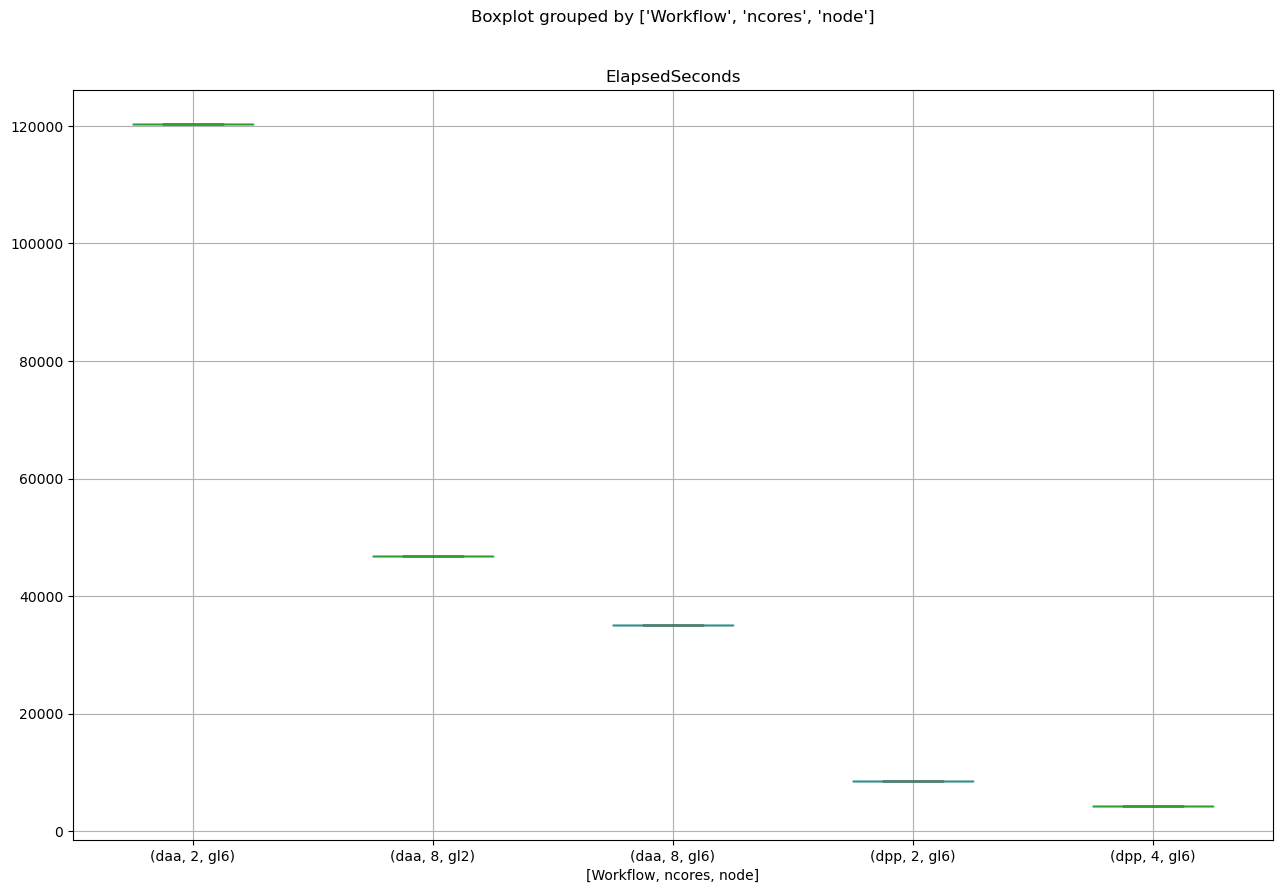

In [291]:
# draw one plot containing multiple boxplots with data distribution curve for each (workflow,ncores,node) agains EnergyConsumption
fig, ax = plt.subplots(figsize=(15, 10))
data.boxplot(column='ElapsedSeconds', by=['Workflow', 'ncores', 'node'], ax=ax)
plt.show()
# save
fig.savefig('boxplot.png')


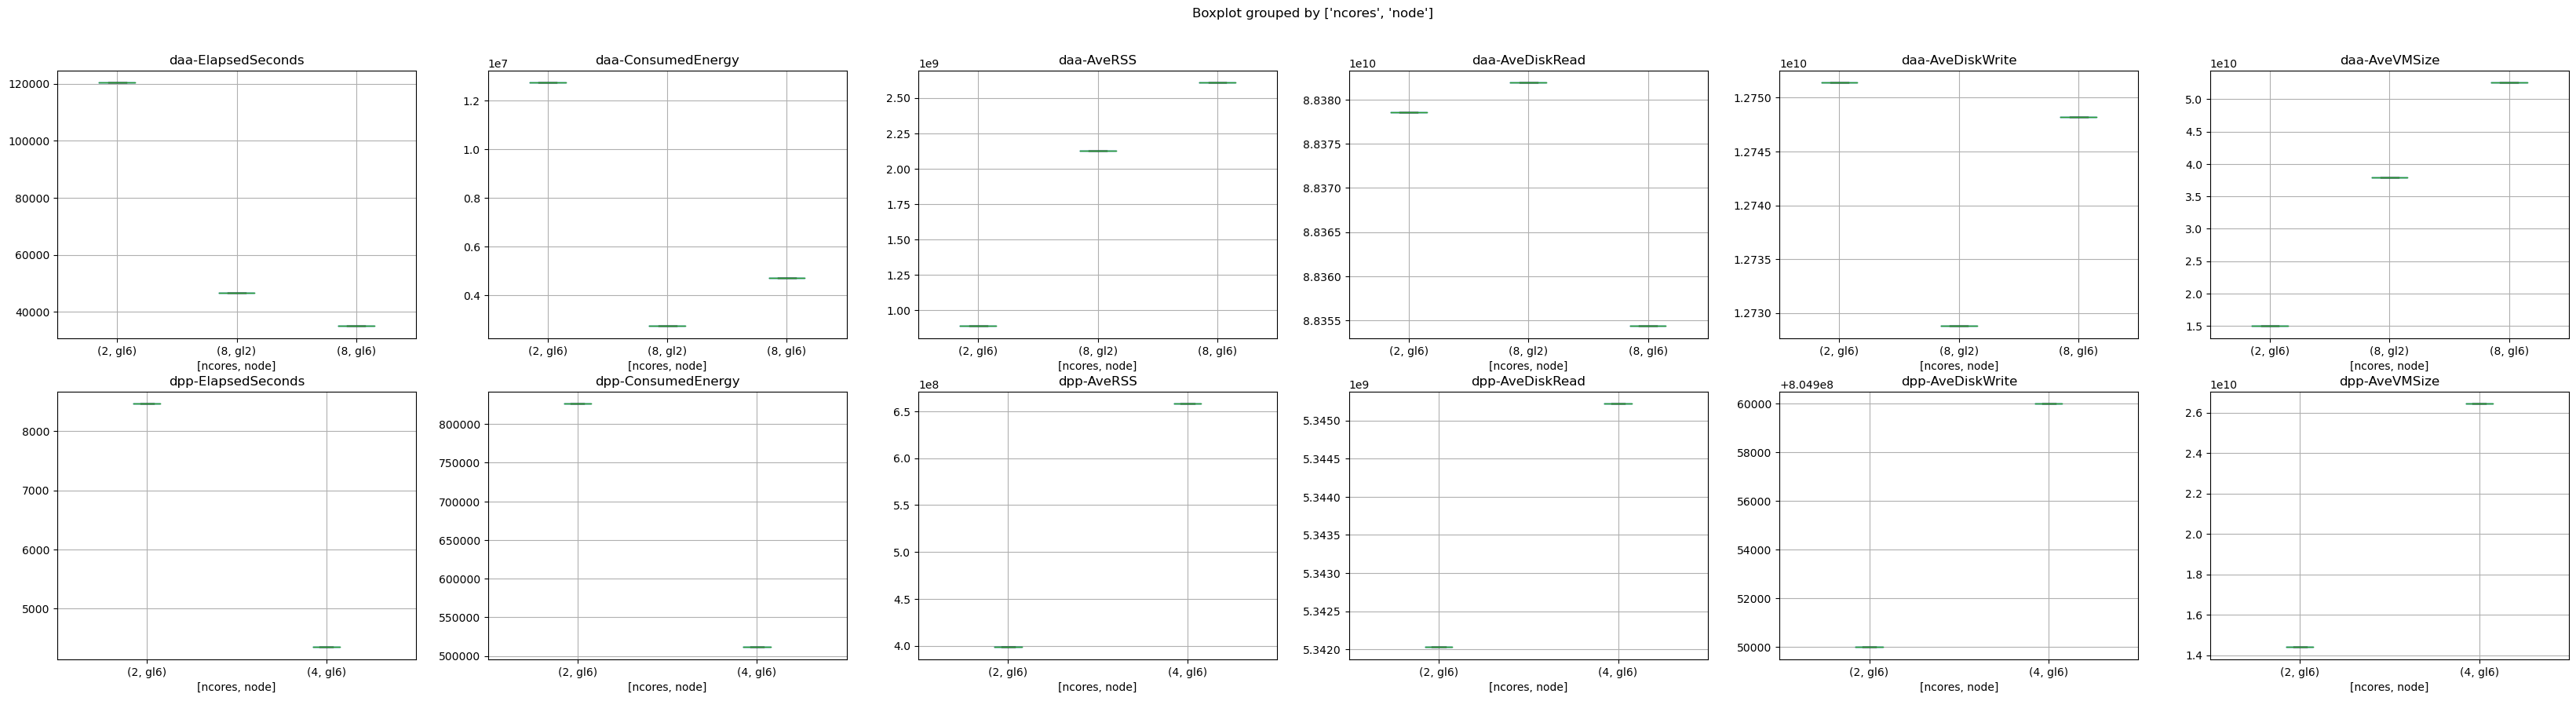

In [292]:
# draw two plots based on workflow containing multiple boxplots with data distribution curve for each (ncores,node) agains ConsumedEnergy, then 2 plots agains AveRSS, AveDiskRead, AveDiskWrite, AveVMSize. Add titles to plots with workflow name. Make sure that it is one big plot that contains all the subplots.
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(40, 10))
for j, workflow in enumerate(data.Workflow.unique()):
    for i, column in enumerate(
            ['ElapsedSeconds', 'ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']):
        data[data.Workflow == workflow].boxplot(column=column, by=['ncores', 'node'], ax=ax[j, i])
        ax[j, i].set_title(f"{workflow}-{column}")
        # next to every boxplot box show data distribution

fig.savefig('boxplot-overview-by-workflows.png')

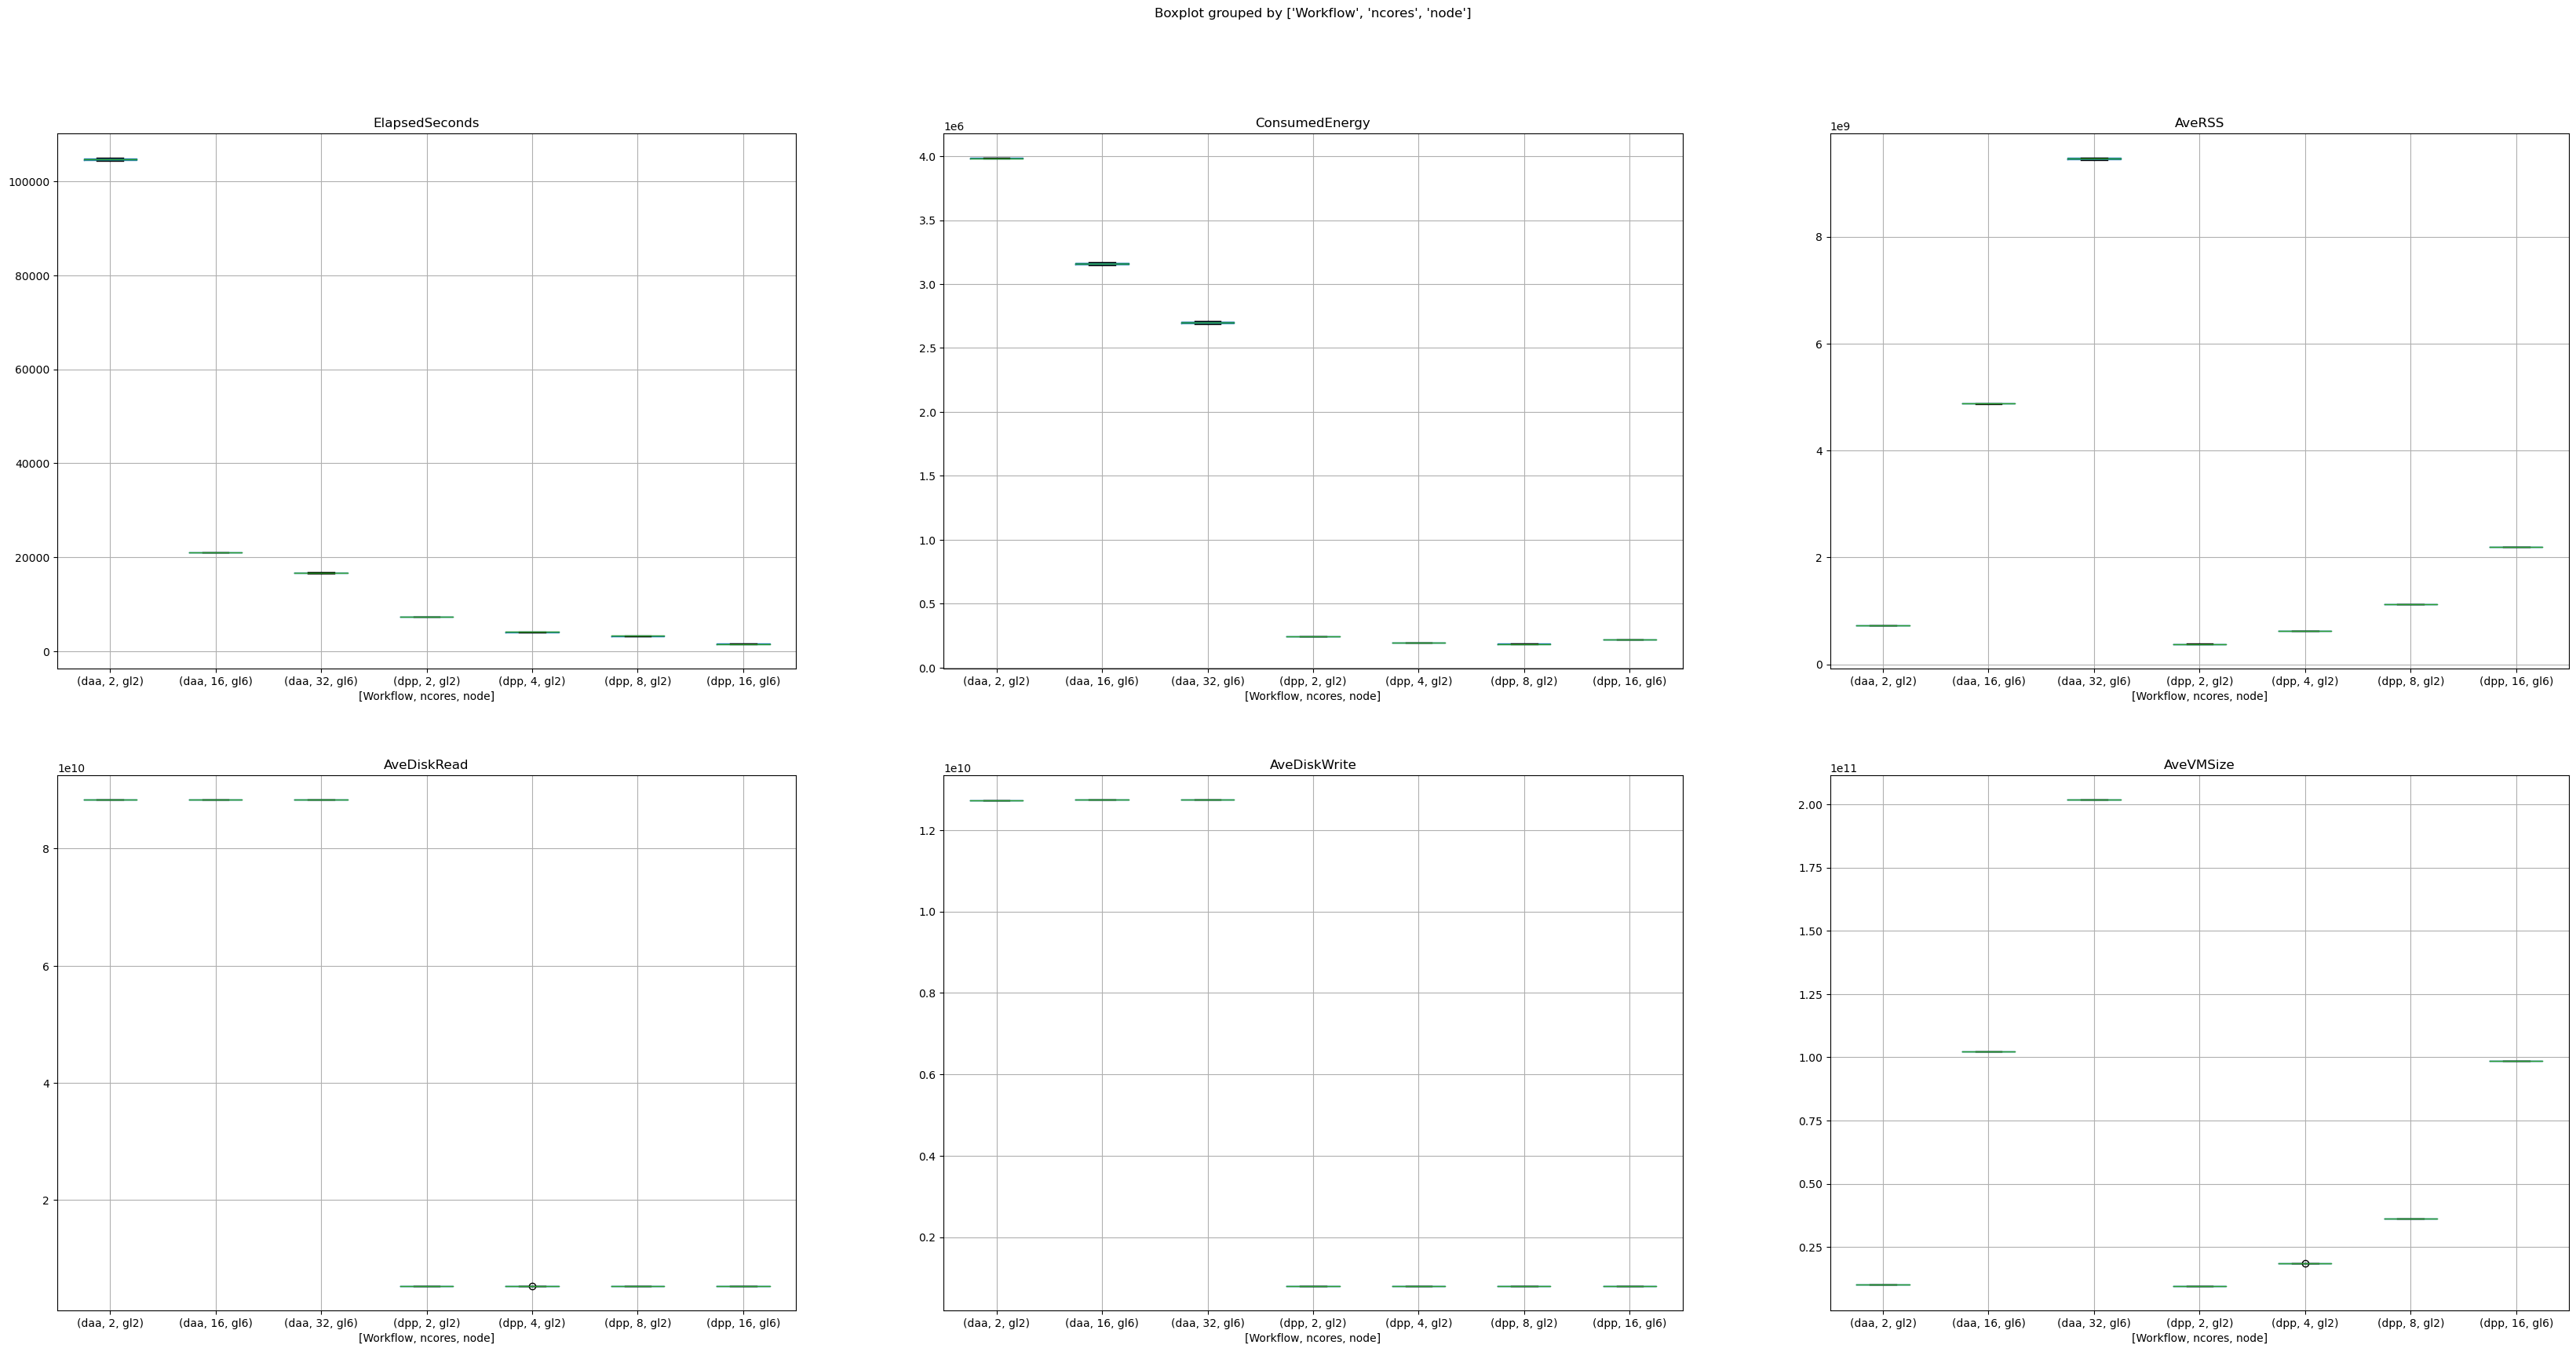

In [245]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(40, 20))
for i, column in enumerate(
        ['ElapsedSeconds', 'ConsumedEnergy', 'AveRSS', 'AveDiskRead', 'AveDiskWrite', 'AveVMSize']):
    data.boxplot(column=column, by=['Workflow', 'ncores', 'node'], ax=ax[i // 3, i % 3])
    ax[i // 3, i % 3].set_title(column)

fig.savefig('boxplot-overview.png')